In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import kagglehub
import cv2

from tensorflow import keras
# Visualization
import matplotlib.pyplot as plt

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Accuracy
from sklearn.metrics import accuracy_score

In [2]:
#Download data set and get the path
path = "dataset"
print("Path to dataset files:", path);

Path to dataset files: dataset


In [ ]:
train_dir = path + "/Training"
test_dir = path + "/Testing"
validation_dir = path + "/Validation"

In [4]:
#for getting class indices
datagen = ImageDataGenerator(rescale=1./255)
datagenTrain = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_dataset = datagenTrain.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
validation_dataset = datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
test_dataset = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
print(train_dataset.class_indices)
print(train_dataset.classes)
print(f"Test {test_dataset.class_indices}")
print(f"Test {test_dataset.classes}")
print(validation_dataset.class_indices)
print(validation_dataset.classes)

Found 4564 images belonging to 4 classes.
Found 1040 images belonging to 4 classes.
Found 880 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
[0 0 0 ... 3 3 3]
Test {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [5]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [6]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:

def accuracy_function(params):

    model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(params['filters'], (params['kernel_size'],params['kernel_size']), activation='relu', input_shape=(150, 150, 3)),
                                    tf.keras.layers.BatchNormalization(),
                                    #then adding a max pooling layer
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    
                                    tf.keras.layers.Conv2D(params['filters']*2, (params['kernel_size'],params['kernel_size']), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    tf.keras.layers.Conv2D(params['filters']*4, (params['kernel_size'],params['kernel_size']), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(params['filters']*8, (params['kernel_size'],params['kernel_size']), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                                    tf.keras.layers.Dropout(0.5),
                                    
                                    tf.keras.layers.Dense(4, activation='softmax')])

    model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(learning_rate=params['learning_rate']),
              metrics=['accuracy'])
    
    history = model.fit(
        train_dataset, 
        epochs=params['epochs'],
        callbacks=[callback], 
        validation_data=validation_dataset, 
    )
    
    # Take the highest validation accuracy after 5 epochs
    accuracy = max(history.history['val_accuracy'])
    
    return accuracy

current_params = initial_params = {
    'kernel_size': 3,
    'filters': 32,
    'learning_rate': 0.0001,
    'epochs': 20
}
current_accuracy = accuracy_function(current_params)

best_params = current_params
best_accuracy = current_accuracy

temp = 10

for i in range(4):
    new_params = {
        'filters': np.random.choice([16, 32, 64]),
        'kernel_size': np.random.choice([3, 5, 7]),
        'learning_rate': 10 ** np.random.uniform(-4, -2),
        'epochs': np.random.choice([10, 15, 20])
    }
    
    new_accuracy = accuracy_function(new_params)
    
    delta = new_accuracy - current_accuracy
    acceptance_probability = np.exp(delta / temp)
    
    if delta > 0 or np.random.rand() < acceptance_probability:
        current_params = new_params
        current_accuracy = new_accuracy
        
        if new_accuracy > best_accuracy:
            best_params = new_params
            best_accuracy = new_accuracy

    temp *= 0.9
    
    print(f"Iteration {i + 1}: Score = {current_accuracy:.4f}, Best Score = {best_accuracy:.4f}\n")
    print("\nParameters:", new_params)

print("\nBest Parameters:", best_params)
print("Best Validation Score:", best_accuracy)


c:\Users\anama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\anama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 457ms/step - accuracy: 0.4873 - loss: 11.5322 - val_accuracy: 0.2962 - val_loss: 12.6206
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 454ms/step - accuracy: 0.6129 - loss: 9.8964 - val_accuracy: 0.4587 - val_loss: 10.2264
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 59s 412ms/step - accuracy: 0.6837 - loss: 8.8693 - val_accuracy: 0.6260 - val_loss: 8.2497
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 434ms/step - accuracy: 0.7101 - loss: 7.8758 - val_accuracy: 0.7529 - val_loss: 7.1727
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 441ms/step - accuracy: 0.7203 - loss: 7.0287 - val_accuracy: 0.6962 - val_loss: 6.5103
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 439ms/step - accuracy: 0.7415 - loss: 6.1992 - val_accuracy: 0.6913 - val_loss: 5.8790
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 430ms/step - accuracy: 0.7484 - loss: 5.4823 - val_accuracy: 0.7096 - val_loss: 5.1343
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 60s 418ms/step - accuracy: 0.7705 - loss

In [ ]:
def create_model(learning_rate):
    model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                                    tf.keras.layers.BatchNormalization(),
                                    #then adding a max pooling layer
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                            

                                    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                                    tf.keras.layers.Dropout(0.5),
                                    #4 because 4 classes
                                    #softmax because we have multiple classes and not binary
                                    tf.keras.layers.Dense(4, activation='softmax')])
    model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(learning_rate=learning_rate),
              metrics=['accuracy'])
    return model

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,815,428 (26.00 MB)

 Trainable params: 6,814,468 (26.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history_dict = {
    'learning-rates' : [0.01, 0.001, 0.0001, 0.00001],
    'acc': []
}

for lr in history_dict['learning-rates']:
    print(f"learning rate: {lr}")
    model = create_model(lr)
    cnn_model = model.fit(train_dataset,
          epochs=20,
          validation_data=validation_dataset,
          callbacks=[callback]) 
    
    history_dict['acc'].append(cnn_model.history['val_accuracy'][-1])

learning_rates = np.array(history_dict['learning-rates'])
acc = np.array(history_dict['acc'])

In [ ]:
plt.plot(learning_rates, acc)
plt.xscale('log')  
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate vs Accuracy')
plt.savefig("lr-acc.png")
plt.show()

In [ ]:
model = create_model(0.0001)

model_fit = model.fit(train_dataset,
          epochs=20,
          validation_data=validation_dataset,
          callbacks=[callback]) 

Epoch 1/20
 11/143 ━━━━━━━━━━━━━━━━━━━━ 53s 404ms/step - accuracy: 0.8346 - loss: 1.2204

: 

In [11]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7636 - loss: 1.4450
Test Accuracy: 77.84%


In [13]:
misclassified_list = []
print(len(y_pred))
for i in range(len(y_pred)):
    if y_pred[i] != test_dataset.classes[i]:
        misclassified_list.append(i)

880


In [ ]:
cout = misclassified_list.__len__()
glioma = 0 
glioma_1 = 0
glioma_2 = 0
glioma_3 = 0
meningiona = 0
meningiona_0 = 0
meningiona_2 = 0
meningiona_3 = 0
notumor = 0
notumor_0 = 0
notumor_1 = 0
notumor_3 = 0

pit = 0
pit_0 = 0
pit_1 = 0
pit_2 = 0

print(cout)
for i in misclassified_list[:1040]:
    img = cv2.imread(test_dataset.filepaths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(test_dataset.classes[i] == 0 and y_pred[i] != 0):
        if(y_pred[i] == 1):
            glioma_1 += 1
        elif(y_pred[i] == 2):
            glioma_2 += 1
        elif(y_pred[i] == 3):
            glioma_3 += 1
        glioma += 1
    elif(test_dataset.classes[i] == 1 and y_pred[i] != 1):
        if(y_pred[i] == 0):
            meningiona_0 += 1
        elif(y_pred[i] == 2):
            meningiona_2 += 1
        elif(y_pred[i] == 3):
            meningiona_3 += 1
        meningiona += 1
    elif(test_dataset.classes[i] == 2 and y_pred[i] != 2):
        if(y_pred[i] == 0):
            notumor_0 += 1
        elif(y_pred[i] == 1):
            notumor_1 += 1
        elif(y_pred[i] == 3):
            notumor_3 += 1
        notumor += 1
    elif(test_dataset.classes[i] == 3 and y_pred[i] != 3):
        if(y_pred[i] == 0):
            pit_0 += 1
        elif(y_pred[i] == 1):
            pit_1 += 1
        elif(y_pred[i] == 2):
            pit_2 += 1
        pit += 1


print(f"Glioma:{glioma}")
print(f"Glioma as meningiona: {glioma_1}")
print(f"Glioma as no tumor: {glioma_2}")
print(f"Glioma as pituitary: {glioma_3}")

print(f"Meningiona: {meningiona}")
print(f"Meningiona as glioma: {meningiona_0}")
print(f"Meningiona as no tumor: {meningiona_2}")
print(f"Meningiona as pituitary: {meningiona_3}")

print(f"No Tumor: {notumor}")
print(f"No Tumor as glioma: {notumor_0}")
print(f"No Tumor as meningiona: {notumor_1}")
print(f"No Tumor as pituitary: {notumor_3}")

print(f"Pituitary: {pit}")
print(f"Pituitary as glioma: {pit_0}")
print(f"Pituitary as meningiona: {pit_1}")
print(f"Pituitary as no tumor: {pit_2}")

print(f"Total Misclassified: {cout}")

650
Glioma:185
Glioma as meningiona: 57
Glioma as no tumor: 68
Glioma as pituitary: 60
Meningiona: 144
Meningiona as glioma: 20
Meningiona as no tumor: 69
Meningiona as pituitary: 55
No Tumor: 157
No Tumor as glioma: 30
No Tumor as meningiona: 71
No Tumor as pituitary: 56
Pituitary: 164
Pituitary as glioma: 19
Pituitary as meningiona: 67
Pituitary as no tumor: 78
Total Misclassified: 650


In [15]:

y_true = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

class_accuracies = {}
for class_id, class_name in enumerate(class_labels):
    class_mask = (y_true == class_id)
    class_accuracy = accuracy_score(y_true[class_mask], y_pred[class_mask])
    class_accuracies[class_name] = class_accuracy

# Print results
for class_name, accuracy in class_accuracies.items():
    print(f"Accuracy for class {class_name}: {accuracy:.2%}")

Accuracy for class glioma: 15.91%
Accuracy for class meningioma: 34.55%
Accuracy for class notumor: 28.64%
Accuracy for class pituitary: 25.45%


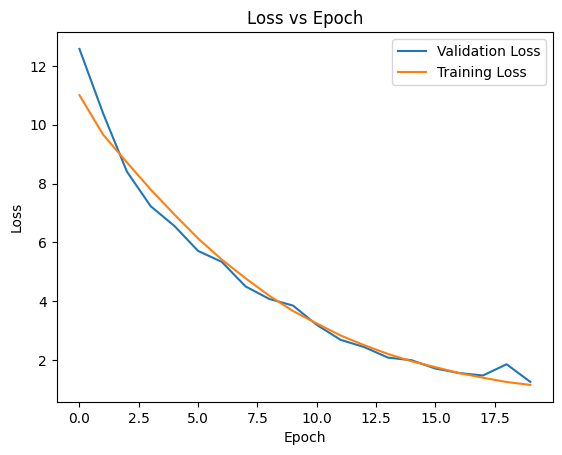

In [16]:
plt.plot(model_fit.history['val_loss'], label='Validation Loss')
plt.plot(model_fit.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.savefig("epoch-loss.png")
plt.show()

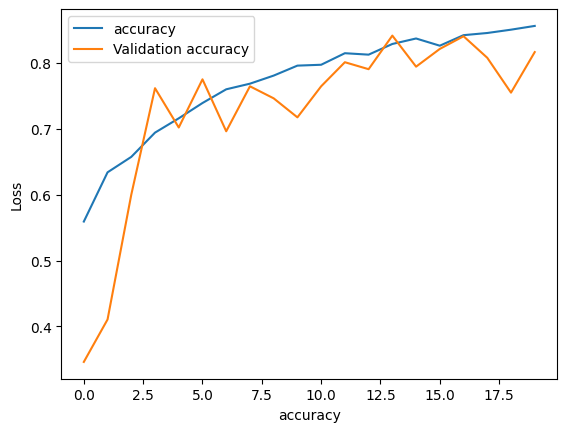

In [17]:
plt.plot(model_fit.history['accuracy'], label='accuracy')
plt.plot(model_fit.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('accuracy')
plt.ylabel('Loss')
plt.legend()
plt.savefig("epoch-acc-augmented.png")
plt.show()